# Stage 1:

## Unsupervised clustering to create a model that labels the output logs:

Uses the data with software fault injection - FLP and NOP

In [147]:
from time import time
import os, random, math
from itertools import permutations

import numpy as np

import pandas as pd

import scipy as sp
import scipy.stats as stats
from scipy.stats import spearmanr

from pypair.association import binary_continuous

from gensim import utils
import gensim.parsing.preprocessing as gsp

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mixed_naive_bayes import MixedNB

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import seaborn as sns

import pickle
import json

In [148]:
path = "Sklearn Models/"

In [149]:
filters = [
           gsp.strip_tags, 
           #gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

In [150]:
def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    s = s.replace("\\n", "")
    for f in filters:
        s = f(s)
    return s

In [152]:
nop_fault_data = pd.read_csv("NovaHomeDaemon_nop_run_all_faulty_executables_random_input.csv")
flp_fault_data = pd.read_csv("NovaHomeDaemon_flp_run_all_faulty_executables_random_input.csv")
none_fault_data = pd.read_csv("NovaHomeDaemon_none.csv")

In [153]:
frames = [nop_fault_data, flp_fault_data[0:50000], none_fault_data[0:50000]]
total_data = pd.concat(frames, ignore_index=True)

In [154]:
total_size = total_data.shape[0]
print("Size of total data: %i" %(total_size))

flp_size = total_data[total_data["Fault_Type"] == "FLP"].shape[0]
print("Size of FLP data: %i with %.3f%%" 
      %(flp_size, flp_size/total_size * 100))

nop_size = total_data[total_data["Fault_Type"] == "NOP"].shape[0]
print("Size of NOP data: %i with %.3f%%" 
      %(nop_size, nop_size/total_size * 100))

none_size = total_data[total_data["Fault_Type"] == "NONE"].shape[0]
print("Size of NONE data: %i with %.3f%%" 
      %(none_size, none_size/total_size * 100))

Size of total data: 116902
Size of FLP data: 50000 with 42.771%
Size of NOP data: 16902 with 14.458%
Size of NONE data: 50000 with 42.771%


In [155]:
X_train_label, X_test_label = train_test_split(total_data, random_state = 0)

In [ ]:
X_train_label['Output'] = X_train_label['Output'].map(lambda x: clean_text(x))

In [624]:
vectorizer_output = TfidfVectorizer()
X_train_vec_output = vectorizer_output.fit_transform(X_train_label['Output'])

In [625]:
true_k = 8
model_log = KMeans(n_clusters=true_k, init='random', max_iter=100, n_init=5)
model_log.fit(X_train_vec_output)

KMeans(init='random', max_iter=100, n_clusters=4, n_init=5)

In [628]:
predicted_log_label = model_log.predict(vectorizer_output.transform(total_data['Output'].map(lambda x: clean_text(x))))
total_data['Label_Log'] = predicted_log_label
total_data.to_csv('clusters.csv')

## Unsupervised clustering to create a model that labels the error logs:

Uses the data with software fault injection - FLP and NOP

In [159]:
X_train_label['Error'] = X_train_label['Error'].map(lambda x: clean_text(x))

In [160]:
vectorizer_error = TfidfVectorizer()
X_train_vec_error = vectorizer_error.fit_transform(X_train_label['Error'])

In [161]:
true_k = 4
model_error = KMeans(n_clusters=true_k, init='random', max_iter=100, n_init=5)
model_error.fit(X_train_vec_error)

KMeans(init='random', max_iter=100, n_clusters=4, n_init=5)

In [162]:
for index, row in total_data.iterrows():
    if row["Time_Out"] == True:
        total_data.at[index, "Time_Out"] = 1
    else:
        total_data.at[index, "Time_Out"] = 0

In [163]:
predicted_error_label = model_error.predict(vectorizer_error.transform(total_data['Error'].map(lambda x: clean_text(x))))
total_data['Label_Error'] = predicted_error_label
total_data.to_csv('clusters.csv')

## Loading data and splitting into train and test

In [188]:
df = pd.read_csv("clusters.csv")
input_data = df[['Temperature', 'Light', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error', 'Fault_Type']]

In [189]:
X = input_data[['Temperature', 'Light', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error']]
y = input_data[['Fault_Type']]

X['Exit_Code'] = X['Exit_Code'].astype("category")
X['Time_Out'] = X['Time_Out'].astype("category")
X['Label_Log'] = X['Label_Log'].astype("category")
X['Label_Error'] = X['Label_Error'].astype("category")

C:\Users\aakas\AppData\Local\Temp\ipykernel_39076\2356245332.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Exit_Code'] = X['Exit_Code'].astype("category")
C:\Users\aakas\AppData\Local\Temp\ipykernel_39076\2356245332.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Time_Out'] = X['Time_Out'].astype("category")
C:\Users\aakas\AppData\Local\Temp\ipykernel_39076\2356245332.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size = 0.5, random_state = 1)

### Separate train and test data for application data and software properties 

In [193]:
X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X, y, stratify=y, random_state = 1)

In [194]:
X_train_app = X_train_sep[['Temperature', 'Light']]
y_train_app = y_train_sep.copy()
X_test_app = X_test_sep[['Temperature', 'Light']]
y_test_app = y_test_sep.copy()

In [195]:
X_train_swp = X_train_sep[['Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error']]
y_train_swp = y_train_sep.copy()
X_test_swp = X_test_sep[['Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error']]
y_test_swp = y_test_sep.copy()

## Feature Selection and correlation with output label

### SelectKBest based on Mutual Information

In [260]:
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X_train, y_train.values.flatten())

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x000001BF6CF1B9A0>)

In [261]:
for i in range(len(fs.scores_)):
    print('Feature %d: %.2f' % (i, fs.scores_[i]))

Feature 0: 0.35
Feature 1: 0.47
Feature 2: 0.28
Feature 3: 0.18
Feature 4: 0.40
Feature 5: 0.22


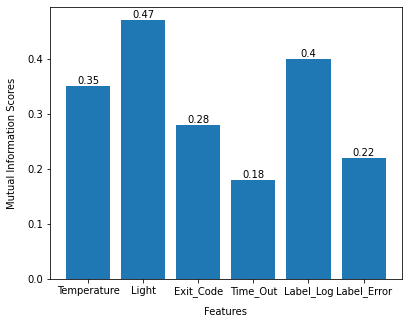

In [278]:
fig, ax1 = plt.subplots(figsize=(6.3, 5))

ax1.bar(['Temperature', 'Light', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error'], fs.scores_)

for container in ax1.containers:
    ax1.bar_label(container)
    
ax1.set_xlabel("Features", labelpad=10)
ax1.set_ylabel("Mutual Information Scores", labelpad=10)

plt.show()

### Cramer's V for Categorical vs Categorical data

In [269]:
def cramers_v(var1, var2):
    data = pd.crosstab(var1, var2).values
    chi_2 = stats.chi2_contingency(data)[0]
    n = data.sum()
    phi_2 = chi_2 / n
    r, k = data.shape
    return np.sqrt(phi_2 / min((k-1), (r-1)))

In [270]:
cramers_v_label_log = cramers_v(X_train['Label_Log'].values.flatten(), y_train.values.flatten())
cramers_v_label_log

0.37

In [271]:
cramers_v_label_error = cramers_v(X_train['Label_Error'].values.flatten(), y_train.values.flatten())
cramers_v_label_error

0.21

In [272]:
cramers_v_time_out = cramers_v(X_train['Time_Out'].values.flatten(), y_train.values.flatten())
cramers_v_time_out

0.17

In [273]:
cramers_v_exit_code = cramers_v(X_train['Exit_Code'].values.flatten(), y_train.values.flatten())
cramers_v_exit_code

0.26

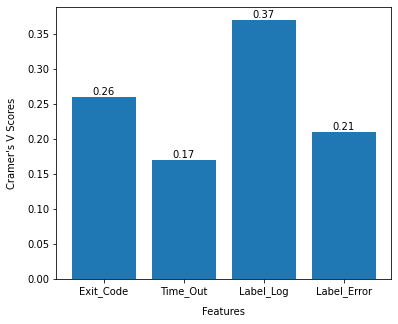

In [275]:
fig, ax1 = plt.subplots(figsize=(6, 5))

ax1.bar(['Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error'], 
        [cramers_v_exit_code, cramers_v_time_out, cramers_v_label_log, cramers_v_label_error])

for container in ax1.containers:
    ax1.bar_label(container)
    
ax1.set_xlabel("Features", labelpad=10)
ax1.set_ylabel("Cramer's V Scores", labelpad=10)

plt.show()

### Kruskal Wallis test for Numerical vs Categorical Data

In [221]:
p_value_temp_flp = stats.kruskal(X_train['Temperature'], y_train['Fault_Type'] == 'FLP')
stats.kruskal(X_train['Temperature'], y_train['Fault_Type'] == 'FLP')

KruskalResult(statistic=35610.267361997525, pvalue=0.04)

In [222]:
p_value_temp_none = stats.kruskal(X_train['Temperature'], y_train['Fault_Type'] == 'NONE')
stats.kruskal(X_train['Temperature'], y_train['Fault_Type'] == 'NONE')

KruskalResult(statistic=35277.06479856109, pvalue=0.1)

In [223]:
p_value_temp_nop = stats.kruskal(X_train['Temperature'], y_train['Fault_Type'] == 'NOP')
stats.kruskal(X_train['Temperature'], y_train['Fault_Type'] == 'NOP')

KruskalResult(statistic=35290.3470271417, pvalue=0.02)

In [224]:
p_value_light_flp = stats.kruskal(X_train['Light'], y_train['Fault_Type'] == 'FLP')
stats.kruskal(X_train['Light'], y_train['Fault_Type'] == 'FLP')

KruskalResult(statistic=23377.12318159441, pvalue=0.01)

In [225]:
p_value_light_none = stats.kruskal(X_train['Light'], y_train['Fault_Type'] == 'NONE')
stats.kruskal(X_train['Light'], y_train['Fault_Type'] == 'NONE')

KruskalResult(statistic=23189.316420025716, pvalue=0.08)

In [226]:
p_value_light_nop = stats.kruskal(X_train['Light'], y_train['Fault_Type'] == 'NOP')
stats.kruskal(X_train['Light'], y_train['Fault_Type'] == 'NOP')

KruskalResult(statistic=23196.751878518233, pvalue=0.05)

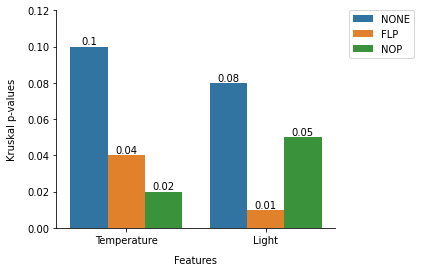

In [279]:
df = pd.DataFrame({
    'Features': ['Temperature', 'Light'],
    'NONE': [p_value_temp_none, p_value_light_none],
    'FLP': [p_value_temp_flp, p_value_light_flp],
    'NOP': [p_value_temp_nop, p_value_light_nop]
})
xlabel = 'Features'
ylabel = 'Kruskal p-values'
fig, ax1 = plt.subplots(figsize=(5, 4))
tidy = df.melt(id_vars=xlabel).rename(columns=str.title)
tidy = tidy.rename(columns={"Value": ylabel, "Variable": "Fault Type"})
sns.barplot(x=xlabel, y=ylabel, hue='Fault Type', data=tidy, ax=ax1)
ax1.set(ylim=(0, 0.12))

for container in ax1.containers:
    ax1.bar_label(container)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel(xlabel, labelpad=10)
ax1.set_ylabel(ylabel, labelpad=10)

sns.despine(fig)

## Training supervised model for fault type predicition - Naive Classifier

In [338]:
naive_model = DummyClassifier(strategy='most_frequent').fit(X_train, y_train.values.flatten())

filePath = "%s/Naive Models/naive_model.sav" %(path)
os.makedirs(os.path.dirname(filePath), exist_ok=True)
fileObj = open(filePath, 'wb')
pickle.dump(naive_model, fileObj)
fileObj.close()

In [339]:
naive_model_nop = DummyClassifier(strategy='constant', constant='NOP').fit(X_train, y_train.values.flatten())

filePath = "%s/Naive Models/naive_model_nop.sav" %(path)
os.makedirs(os.path.dirname(filePath), exist_ok=True)
fileObj = open(filePath, 'wb')
pickle.dump(naive_model_nop, fileObj)
fileObj.close()

In [340]:
naive_model_flp = DummyClassifier(strategy='constant', constant='FLP').fit(X_train, y_train.values.flatten())

filePath = "%s/Naive Models/naive_model_flp.sav" %(path)
os.makedirs(os.path.dirname(filePath), exist_ok=True)
fileObj = open(filePath, 'wb')
pickle.dump(naive_model_flp, fileObj)
fileObj.close()

In [341]:
naive_model_none = DummyClassifier(strategy='constant', constant='NONE').fit(X_train, y_train.values.flatten())

filePath = "%s/Naive Models/naive_model_none.sav" %(path)
os.makedirs(os.path.dirname(filePath), exist_ok=True)
fileObj = open(filePath, 'wb')
pickle.dump(naive_model_none, fileObj)
fileObj.close()

## Training supervised model for fault type predicition - KNN

In [10]:
t0 = time()
knn = KNeighborsClassifier(algorithm='auto', leaf_size=60, n_neighbors=554, 
                           weights='distance', n_jobs=1).fit(X_train, y_train.values.flatten())
knn_fit_time = time() - t0

In [11]:
print("knn_fit_time: %d" %(knn_fit_time))

knn_fit_time: 0


### KNN - Nested CV

In [122]:
cv_outer_knn = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [123]:
accuracy_scores_knn=[]
precision_scores_knn=[]
recall_scores_knn=[]
f1_scores_knn=[]

In [124]:
t0 = time()
count = 0
for train_ix, test_ix in cv_outer_knn.split(X, y):
    print(train_ix)
    print(test_ix)
    X_train_cv_knn, X_test_cv_knn = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train_cv_knn, y_test_cv_knn = y.iloc[train_ix], y.iloc[test_ix]
    
    cv_inner_knn = KFold(n_splits=5, shuffle=True, random_state=1)
    
    knn_kfold = KNeighborsClassifier(n_jobs=1)
    
    n_neighbors = [int(x) for x in np.linspace(start = 10, stop = 700, num = 20)]
    
    weights = ['uniform', 'distance']
    
    algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
    
    leaf_sizes = [30, 60, 90, 150, 200]
    
    random_grid = {'n_neighbors': n_neighbors,
                   'weights': weights,
                   'algorithm': algorithms,
                   'leaf_size': leaf_sizes}
    
    knn_random_kfold = RandomizedSearchCV(estimator=knn_kfold, param_distributions=random_grid, n_iter=5, cv=cv_inner_knn, 
                                   verbose=2, random_state=42, n_jobs = 2)
    
    result_knn = knn_random_kfold.fit(X_train_cv_knn, y_train_cv_knn.values.flatten())
    
    knn_random_kfold_best = knn_random_kfold.best_estimator_
    
    filePath = "%s/KNN Models/KFold Models/kfold_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(knn_random_kfold_best, fileObj)
    fileObj.close()
    
    ypred_knn_random_kfold = knn_random_kfold_best.predict(X_test_cv_knn)
    accuracy_this_fold_knn = accuracy_score(y_test_cv_knn, ypred_knn_random_kfold)
    precision_this_fold_knn = precision_score(y_test_cv_knn, ypred_knn_random_kfold, average='weighted')
    recall_this_fold_knn = recall_score(y_test_cv_knn, ypred_knn_random_kfold, average='weighted')
    f1_score_this_fold_knn = f1_score(y_test_cv_knn, ypred_knn_random_kfold, average='weighted')
    
    print("Best Score: %.3f, with parameters: %s" %(result_knn.best_score_, result_knn.best_params_))    
    
    print("Accuracy: %.3f" %(accuracy_this_fold_knn))
    print("Precision: %.3f" %(precision_this_fold_knn))
    print("Recall: %.3f" %(recall_this_fold_knn))
    print("F1 Score: %.3f" %(f1_score_this_fold_knn))
    
    accuracy_scores_knn.append(accuracy_this_fold_knn)
    precision_scores_knn.append(precision_this_fold_knn)
    recall_scores_knn.append(recall_this_fold_knn)
    f1_scores_knn.append(f1_score_this_fold_knn)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")

nested_cv_time_knn = time() - t0

[     0      1      2 ... 116898 116899 116900]
[    17     47     53 ... 116880 116888 116901]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   9.7s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.8s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.9s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.4s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.5s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   8.1s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.1s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   5.6s


[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.3s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.3s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.3s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.4s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.3s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.9s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.8s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.8s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.3s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.2s
[CV] END algorithm=ball_tree, leaf_size=60, n_neighbors=554,

[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.4s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.2s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.1s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.7s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.1s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.4s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.4s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.3s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.2s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.4s
[CV] END algorithm=ball_tree, leaf_size=60, n_neighbors=554,

[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.1s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   5.0s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.7s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.6s
[CV] END algorithm=auto, leaf_size=90, n_neighbors=409, weights=uniform; total time=   4.5s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.9s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.2s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.2s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   6.6s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=627, weights=distance; total time=   5.9s
[CV] END algorithm=ball_tree, leaf_size=60, n_neighbors=554,

In [513]:
knn_random_kfold.best_params_

{'weights': 'distance',
 'n_neighbors': 554,
 'leaf_size': 60,
 'algorithm': 'auto'}

In [514]:
print("nested_cv_time_knn: %d" %(nested_cv_time_knn))

nested_cv_time_knn: 779


In [148]:
filePathAcc = "%s/KNN Models/KFold Models/kfold_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/KNN Models/KFold Models/kfold_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/KNN Models/KFold Models/kfold_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/KNN Models/KFold Models/kfold_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_knn, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_knn, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_knn, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_knn, filehandle)

In [71]:
filePathAcc = "%s/KNN Models/KFold Models/kfold_accuracy_scores.txt" %(path)

filePathPrec = "%s/KNN Models/KFold Models/kfold_precision_scores.txt" %(path)

filePathRecall = "%s/KNN Models/KFold Models/kfold_recall_scores.txt" %(path)

filePathF1 = "%s/KNN Models/KFold Models/kfold_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_knn = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_knn = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_knn = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_knn = data

In [72]:
accuracy_scores_knn = np.asarray(accuracy_scores_knn)
precision_scores_knn = np.asarray(precision_scores_knn)
recall_scores_knn = np.asarray(recall_scores_knn)
f1_scores_knn = np.asarray(f1_scores_knn)

print("K-NN K-fold Mean Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_knn.mean(), 
                                                                 (accuracy_scores_knn.std())))

print("K-NN K-fold Mean Precision: %.3f, with deviation of: %.3f" %(precision_scores_knn.mean(), 
                                                                  precision_scores_knn.std()))

print("K-NN K-fold Mean Recall: %.3f, with deviation of: %.3f" %(recall_scores_knn.mean(), 
                                                               recall_scores_knn.std()))

print("K-NN K-fold Mean F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_knn.mean(), 
                                                                 f1_scores_knn.std()))

K-NN K-fold Mean Accuracy: 0.623, with deviation of: 0.002
K-NN K-fold Mean Precision: 0.809, with deviation of: 0.004
K-NN K-fold Mean Recall: 0.623, with deviation of: 0.002
K-NN K-fold Mean F1 Score: 0.603, with deviation of: 0.003


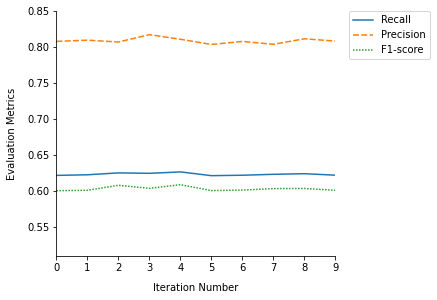

In [280]:
knn_kfold_plot_data = pd.DataFrame({
    'Recall': recall_scores_knn,
    'Precision': precision_scores_knn,
    'F1-score': f1_scores_knn
})
fig, ax1 = plt.subplots(figsize=(5, 4.5))
knn_kfold_lineplot = sns.lineplot(data=knn_kfold_plot_data, ax=ax1)
ax1.set(xlim=(0, 9))
ax1.set(ylim=(0.51, 0.85))
ax1.set_xlabel("Iteration Number", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
sns.despine(fig)

### KNN - Testing model with different percentages of train and test data

In [125]:
accuracy_scores_tt_knn=[]
precision_scores_tt_knn=[]
recall_scores_tt_knn=[]
f1_scores_tt_knn=[]

In [126]:
t0 = time()
count = 0
for ratio in [(0.9,0.1), (0.8,0.2), (0.75,0.25), (0.6,0.4), (0.5,0.5), (0.4,0.6), (0.3, 0.7), (0.15, 0.85)]:
    print("Train: %.2f and Test: %.2f" %(ratio[0], ratio[1]))
    
    X_train_tt_knn, X_test_tt_knn, y_train_tt_knn, y_test_tt_knn = train_test_split(X, y, train_size=ratio[0], random_state = 1)
    
    knn_tt = KNeighborsClassifier(n_jobs=2, 
                                 weights='distance',
                                 n_neighbors=554,
                                 leaf_size=60)\
    .fit(X_train_tt_knn, y_train_tt_knn.values.flatten())
    
    filePath = "%s/KNN Models/TT Models/tt_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(knn_tt, fileObj)
    fileObj.close()
    
    ypred_knn_tt = knn_tt.predict(X_test_tt_knn)
    
    accuracy_tt_knn = accuracy_score(y_test_tt_knn, ypred_knn_tt)
    precision_tt_knn = precision_score(y_test_tt_knn, ypred_knn_tt, average='weighted')
    recall_tt_knn = recall_score(y_test_tt_knn, ypred_knn_tt, average='weighted')
    f1_score_tt_knn = f1_score(y_test_tt_knn, ypred_knn_tt, average='weighted')   
    
    print("Accuracy: %.3f" %(accuracy_tt_knn))
    print("Precision: %.3f" %(precision_tt_knn))
    print("Recall: %.3f" %(recall_tt_knn))
    print("F1 Score: %.3f" %(f1_score_tt_knn))
    
    accuracy_scores_tt_knn.append(accuracy_tt_knn)
    precision_scores_tt_knn.append(precision_tt_knn)
    recall_scores_tt_knn.append(recall_tt_knn)
    f1_scores_tt_knn.append(f1_score_tt_knn)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
train_test_time_knn = time() - t0

Train: 0.90 and Test: 0.10
Accuracy: 0.876
Precision: 0.895
Recall: 0.876
F1 Score: 0.843
-------------------------------------------------------------------------------------------------------------------
Train: 0.80 and Test: 0.20
Accuracy: 0.875
Precision: 0.896
Recall: 0.875
F1 Score: 0.843
-------------------------------------------------------------------------------------------------------------------
Train: 0.75 and Test: 0.25
Accuracy: 0.874
Precision: 0.893
Recall: 0.874
F1 Score: 0.843
-------------------------------------------------------------------------------------------------------------------
Train: 0.60 and Test: 0.40
Accuracy: 0.874
Precision: 0.889
Recall: 0.874
F1 Score: 0.843
-------------------------------------------------------------------------------------------------------------------
Train: 0.50 and Test: 0.50
Accuracy: 0.873
Precision: 0.890
Recall: 0.873
F1 Score: 0.842
--------------------------------------------------------------------------------------

In [519]:
print("train_test_time_knn: %d" %(train_test_time_knn))

train_test_time_knn: 87


In [342]:
filePathAcc = "%s/KNN Models/TT Models/tt_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/KNN Models/TT Models/tt_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/KNN Models/TT Models/tt_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/KNN Models/TT Models/tt_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_tt_knn, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_tt_knn, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_tt_knn, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_tt_knn, filehandle)

In [75]:
filePathAcc = "%s/KNN Models/TT Models/tt_accuracy_scores.txt" %(path)

filePathPrec = "%s/KNN Models/TT Models/tt_precision_scores.txt" %(path)

filePathRecall = "%s/KNN Models/TT Models/tt_recall_scores.txt" %(path)

filePathF1 = "%s/KNN Models/TT Models/tt_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_tt_knn = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_tt_knn = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_tt_knn = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_tt_knn = data

In [76]:
accuracy_scores_tt_knn = np.asarray(accuracy_scores_tt_knn)
precision_scores_tt_knn = np.asarray(precision_scores_tt_knn)
recall_scores_tt_knn = np.asarray(recall_scores_tt_knn)
f1_scores_tt_knn = np.asarray(f1_scores_tt_knn)

print("K-NN TT Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_tt_knn.mean(), 
                                                                 (accuracy_scores_tt_knn.std())))

print("K-NN TT Precision: %.3f, with deviation of: %.3f" %(precision_scores_tt_knn.mean(), 
                                                                  precision_scores_tt_knn.std()))

print("K-NN TT Recall: %.3f, with deviation of: %.3f" %(recall_scores_tt_knn.mean(), 
                                                               recall_scores_tt_knn.std()))

print("K-NN TT F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_tt_knn.mean(), 
                                                                 f1_scores_tt_knn.std()))

K-NN TT Accuracy: 0.871, with deviation of: 0.006
K-NN TT Precision: 0.886, with deviation of: 0.011
K-NN TT Recall: 0.871, with deviation of: 0.006
K-NN TT F1 Score: 0.840, with deviation of: 0.005


C:\Users\aakas\AppData\Local\Temp\ipykernel_39076\2930073975.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  knn_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)",


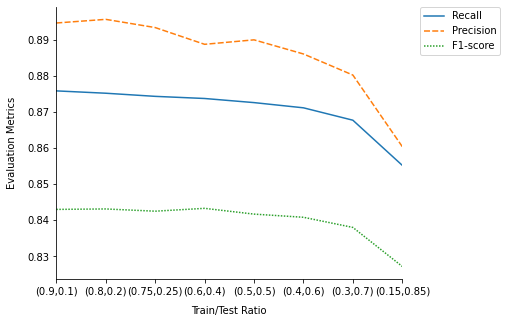

In [281]:
knn_train_test_plot_data = pd.DataFrame({
    'Recall': recall_scores_tt_knn,
    'Precision': precision_scores_tt_knn,
    'F1-score': f1_scores_tt_knn
})
fig, ax1 = plt.subplots(figsize=(6.2, 5))
knn_tt_lineplot = sns.lineplot(data=knn_train_test_plot_data, ax=ax1)
ax1.set(xlim=(0, 7))
ax1.set_xlabel("Train/Test Ratio", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
knn_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)", 
                   "(0.4,0.6)", "(0.3,0.7)", "(0.15,0.85)"])
sns.despine(fig)

## Training supervised model for fault type predicition - Random Forest

In [196]:
t0 = time()
rfc = RandomForestClassifier(n_estimators=20, min_samples_split=350, min_samples_leaf=350,
                             max_features='sqrt', max_depth=7, bootstrap=False, 
                             random_state=0, criterion="entropy").fit(X_train, y_train.values.flatten())
rf_fit_time = time() - t0

In [197]:
print("rf_fit_time: %d" %(rf_fit_time))

rf_fit_time: 0


### Random Forest - Separate model training for application data and software properties 

In [198]:
t0 = time()
rfc_app = RandomForestClassifier(n_estimators=50, min_samples_split=50, min_samples_leaf=200,
                             max_features='auto', max_depth=15, bootstrap=False, 
                             random_state=0, criterion="entropy").fit(X_train_app, y_train_app.values.flatten())
rf_app_fit_time = time() - t0

In [199]:
print("rf_app_fit_time: %d" %(rf_app_fit_time))

rf_app_fit_time: 1


In [200]:
t0 = time()
rfc_swp = RandomForestClassifier(n_estimators=50, min_samples_split=50, min_samples_leaf=200,
                             max_features='auto', max_depth=15, bootstrap=False, 
                             random_state=0, criterion="entropy").fit(X_train_swp, y_train_swp.values.flatten())
rf_swp_fit_time = time() - t0

In [201]:
print("rf_swp_fit_time: %d" %(rf_swp_fit_time))

rf_swp_fit_time: 0


### Random Forest - Nested CV

In [89]:
cv_outer = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [90]:
accuracy_scores=[]
precision_scores=[]
recall_scores=[]
f1_scores=[]

In [91]:
t0 = time()
count = 0
for train_ix, test_ix in cv_outer.split(X, y):
    print(train_ix)
    print(test_ix)
    X_train_cv, X_test_cv = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train_cv, y_test_cv = y.iloc[train_ix], y.iloc[test_ix]
    
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    
    rfc_kfold = RandomForestClassifier(random_state=0, criterion="entropy")
    
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(2, 20, num = 11)]
    max_depth.append(None)
    min_samples_split = [10, 20, 50, 70, 100]
    min_samples_leaf = [100, 200, 300, 400, 500]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rf_random_kfold = RandomizedSearchCV(estimator=rfc_kfold, param_distributions=random_grid, n_iter=5, cv=cv_inner, 
                                   verbose=2, random_state=42, n_jobs = 2)
    
    result = rf_random_kfold.fit(X_train_cv, y_train_cv.values.flatten())
    
    rfc_random_kfold_best = rf_random_kfold.best_estimator_
    
    filePath = "%s/Random Forest Models/KFold Models/kfold_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(rfc_random_kfold_best, fileObj)
    fileObj.close()
    
    ypred_rfc_random_kfold = rfc_random_kfold_best.predict(X_test_cv)
    accuracy_this_fold = accuracy_score(y_test_cv, ypred_rfc_random_kfold)
    precision_this_fold = precision_score(y_test_cv, ypred_rfc_random_kfold, average='weighted')
    recall_this_fold = recall_score(y_test_cv, ypred_rfc_random_kfold, average='weighted')
    f1_score_this_fold = f1_score(y_test_cv, ypred_rfc_random_kfold, average='weighted')
    
    print("Best Score: %.3f, with parameters: %s" %(result.best_score_, result.best_params_))    
    
    print("Accuracy: %.3f" %(accuracy_this_fold))
    print("Precision: %.3f" %(precision_this_fold))
    print("Recall: %.3f" %(recall_this_fold))
    print("F1 Score: %.3f" %(f1_score_this_fold))
    
    accuracy_scores.append(accuracy_this_fold)
    precision_scores.append(precision_this_fold)
    recall_scores.append(recall_this_fold)
    f1_scores.append(f1_score_this_fold)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")

nested_cv_time = time() - t0

[     0      1      2 ... 116898 116899 116900]
[    17     47     53 ... 116880 116888 116901]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.882, with parameters: {'n_estimators': 160, 'min_samples_split': 70, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 18, 'bootstrap': False}
Accuracy: 0.884
Precision: 0.906
Recall: 0.884
F1 Score: 0.852
-------------------------------------------------------------------------------------------------------------------
[     0      1      3 ... 116899 116900 116901]
[     2     19     21 ... 116882 116883 116897]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.882, with parameters: {'n_estimators': 160, 'min_samples_split': 70, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 18, 'bootstrap': False}
Accuracy: 0.883
Precision: 0.905
Recall: 0.883
F1 Score: 0.852
------------------------------------------------------------------------------------------------------------

In [92]:
print("nested_cv_time: %d" %(nested_cv_time))

nested_cv_time: 246


In [93]:
rf_random_kfold.best_params_

{'n_estimators': 160,
 'min_samples_split': 70,
 'min_samples_leaf': 100,
 'max_features': 'sqrt',
 'max_depth': 18,
 'bootstrap': False}

In [346]:
filePathAcc = "%s/Random Forest Models/KFold Models/kfold_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/Random Forest Models/KFold Models/kfold_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/Random Forest Models/KFold Models/kfold_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/Random Forest Models/KFold Models/kfold_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores, filehandle)

TypeError: Object of type ndarray is not JSON serializable

In [84]:
filePathAcc = "%s/Random Forest Models/KFold Models/kfold_accuracy_scores.txt" %(path)

filePathPrec = "%s/Random Forest Models/KFold Models/kfold_precision_scores.txt" %(path)

filePathRecall = "%s/Random Forest Models/KFold Models/kfold_recall_scores.txt" %(path)

filePathF1 = "%s/Random Forest Models/KFold Models/kfold_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores = data

In [85]:
accuracy_scores = np.asarray(accuracy_scores)
precision_scores = np.asarray(precision_scores)
recall_scores = np.asarray(recall_scores)
f1_scores = np.asarray(f1_scores)

print("RF K-fold Mean Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores.mean(), 
                                                                 (accuracy_scores.std())))

print("RF K-fold Mean Precision: %.3f, with deviation of: %.3f" %(precision_scores.mean(), 
                                                                  precision_scores.std()))

print("RF K-fold Mean Recall: %.3f, with deviation of: %.3f" %(recall_scores.mean(), 
                                                               recall_scores.std()))

print("RF K-fold Mean F1 Score: %.3f, with deviation of: %.3f" %(f1_scores.mean(), 
                                                                 f1_scores.std()))

RF K-fold Mean Accuracy: 0.882, with deviation of: 0.001
RF K-fold Mean Precision: 0.904, with deviation of: 0.002
RF K-fold Mean Recall: 0.882, with deviation of: 0.001
RF K-fold Mean F1 Score: 0.850, with deviation of: 0.003


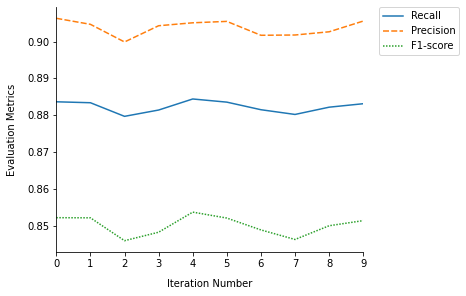

In [282]:
rf_kfold_plot_data = pd.DataFrame({
    'Recall': recall_scores,
    'Precision': precision_scores,
    'F1-score': f1_scores
})
fig, ax1 = plt.subplots(figsize=(5.5, 4.5))
rf_kfold_lineplot = sns.lineplot(data=rf_kfold_plot_data, ax=ax1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel("Iteration Number", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
ax1.set(xlim=(0, 9))

sns.despine(fig)

### Random Forest - Testing model with different percentages of train and test data

In [106]:
accuracy_scores_tt=[]
precision_scores_tt=[]
recall_scores_tt=[]
f1_scores_tt=[]

In [107]:
t0 = time()
count = 0
for ratio in [(0.9,0.1), (0.8,0.2), (0.75,0.25), (0.6,0.4), (0.5,0.5), (0.4,0.6), (0.3, 0.7), (0.15, 0.85)]:
    print("Train: %.2f and Test: %.2f" %(ratio[0], ratio[1]))
    
    X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X, y, train_size=ratio[0], random_state = 1)
    
    rfc_tt = RandomForestClassifier(n_estimators=50, min_samples_split=50, min_samples_leaf=200,
                             max_features='auto', max_depth=15, bootstrap=False, 
                             random_state=0, criterion="entropy")\
    .fit(X_train_tt, y_train_tt.values.flatten())
    
    filePath = "%s/Random Forest Models/TT Models/tt_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(rfc_tt, fileObj)
    fileObj.close()
    
    ypred_rfc_tt = rfc_tt.predict(X_test_tt)
    
    accuracy_tt = accuracy_score(y_test_tt, ypred_rfc_tt)
    precision_tt = precision_score(y_test_tt, ypred_rfc_tt, average='weighted')
    recall_tt = recall_score(y_test_tt, ypred_rfc_tt, average='weighted')
    f1_score_tt = f1_score(y_test_tt, ypred_rfc_tt, average='weighted')   
    
    print("Accuracy: %.3f" %(accuracy_tt))
    print("Precision: %.3f" %(precision_tt))
    print("Recall: %.3f" %(recall_tt))
    print("F1 Score: %.3f" %(f1_score_tt))
    
    accuracy_scores_tt.append(accuracy_tt)
    precision_scores_tt.append(precision_tt)
    recall_scores_tt.append(recall_tt)
    f1_scores_tt.append(f1_score_tt)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
train_test_time = time() - t0

Train: 0.90 and Test: 0.10
Accuracy: 0.878
Precision: 0.902
Recall: 0.878
F1 Score: 0.845
-------------------------------------------------------------------------------------------------------------------
Train: 0.80 and Test: 0.20
Accuracy: 0.880
Precision: 0.904
Recall: 0.880
F1 Score: 0.847
-------------------------------------------------------------------------------------------------------------------
Train: 0.75 and Test: 0.25
Accuracy: 0.880
Precision: 0.903
Recall: 0.880
F1 Score: 0.847
-------------------------------------------------------------------------------------------------------------------
Train: 0.60 and Test: 0.40
Accuracy: 0.879
Precision: 0.902
Recall: 0.879
F1 Score: 0.848
-------------------------------------------------------------------------------------------------------------------
Train: 0.50 and Test: 0.50
Accuracy: 0.876
Precision: 0.900
Recall: 0.876
F1 Score: 0.842
--------------------------------------------------------------------------------------

In [108]:
print("train_test_time: %d" %(train_test_time))

train_test_time: 16


In [109]:
filePathAcc = "%s/Random Forest Models/TT Models/tt_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/Random Forest Models/TT Models/tt_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/Random Forest Models/TT Models/tt_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/Random Forest Models/TT Models/tt_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_tt, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_tt, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_tt, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_tt, filehandle)

In [90]:
filePathAcc = "%s/Random Forest Models/TT Models/tt_accuracy_scores.txt" %(path)

filePathPrec = "%s/Random Forest Models/TT Models/tt_precision_scores.txt" %(path)

filePathRecall = "%s/Random Forest Models/TT Models/tt_recall_scores.txt" %(path)

filePathF1 = "%s/Random Forest Models/TT Models/tt_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_tt = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_tt = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_tt = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_tt = data

In [91]:
accuracy_scores_tt = np.asarray(accuracy_scores_tt)
precision_scores_tt = np.asarray(precision_scores_tt)
recall_scores_tt = np.asarray(recall_scores_tt)
f1_scores_tt = np.asarray(f1_scores_tt)

print("RF TT Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_tt.mean(), 
                                                                 (accuracy_scores_tt.std())))

print("RF TT Precision: %.3f, with deviation of: %.3f" %(precision_scores_tt.mean(), 
                                                                  precision_scores_tt.std()))

print("RF TT Recall: %.3f, with deviation of: %.3f" %(recall_scores_tt.mean(), 
                                                               recall_scores_tt.std()))

print("RF TT F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_tt.mean(), 
                                                                 f1_scores_tt.std()))

RF TT Accuracy: 0.877, with deviation of: 0.004
RF TT Precision: 0.901, with deviation of: 0.002
RF TT Recall: 0.877, with deviation of: 0.004
RF TT F1 Score: 0.842, with deviation of: 0.005


C:\Users\aakas\AppData\Local\Temp\ipykernel_39076\3333351608.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  rf_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)",


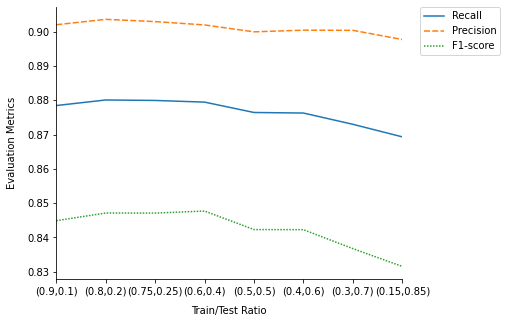

In [283]:
rf_train_test_plot_data = pd.DataFrame({
    'Recall': recall_scores_tt,
    'Precision': precision_scores_tt,
    'F1-score': f1_scores_tt
})
fig, ax1 = plt.subplots(figsize=(6.2, 5))
rf_tt_lineplot = sns.lineplot(data=rf_train_test_plot_data, ax=ax1)
ax1.set(xlim=(0, 7))
ax1.set_xlabel("Train/Test Ratio", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
rf_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)", 
                   "(0.4,0.6)", "(0.3,0.7)", "(0.15,0.85)"])
sns.despine(fig)

## Training supervised model for fault type predicition - XGB

In [502]:
y_train_2 = y_train.copy()
y_train_2.Fault_Type = pd.Categorical(y_train_2.Fault_Type)
y_train_2['Fault_Type_Codes'] = y_train_2.Fault_Type.cat.codes
y_train_2 = y_train_2.drop(columns=['Fault_Type'])
y_train_2 = y_train_2.rename(columns={"Fault_Type_Codes": "Fault_Type"})

In [503]:
t0 = time()
xgb = XGBClassifier(booster='dart', objective='multi:softmax', eval_metric='merror',
                    tree_method='approx', enable_categorical=True, grow_policy='depthwise', 
                    min_child_weight=5, max_depth=5, reg_alpha=2).fit(X_train, y_train_2.values.flatten())
xgb_fit_time = time() - t0

In [504]:
print("xgb_fit_time: %d" %(xgb_fit_time))

xgb_fit_time: 32


### Nested CV

In [113]:
cv_outer_xgb = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [114]:
accuracy_scores_nested_cv_xgb=[]
precision_scores_nested_cv_xgb=[]
recall_scores_nested_cv_xgb=[]
f1_scores_nested_cv_xgb=[]

In [115]:
t0 = time()
count = 0
for train_ix_xgb, test_ix_xgb in cv_outer.split(X, y):
    X_train_cv_xgb, X_test_cv_xgb = X.iloc[train_ix_xgb, :], X.iloc[test_ix_xgb, :]
    y_train_cv_xgb_raw, y_test_cv_xgb_raw = y.iloc[train_ix_xgb], y.iloc[test_ix_xgb]
    
    y_train_cv_xgb = y_train_cv_xgb_raw.copy()
    y_train_cv_xgb.Fault_Type = pd.Categorical(y_train_cv_xgb.Fault_Type)
    y_train_cv_xgb['Fault_Type_Codes'] = y_train_cv_xgb.Fault_Type.cat.codes
    y_train_cv_xgb = y_train_cv_xgb.drop(columns=['Fault_Type'])
    y_train_cv_xgb = y_train_cv_xgb.rename(columns={"Fault_Type_Codes": "Fault_Type"})
    print("Encoded Train Labels")
    
    y_test_cv_xgb = y_test_cv_xgb_raw.copy()
    y_test_cv_xgb.Fault_Type = pd.Categorical(y_test_cv_xgb.Fault_Type)
    y_test_cv_xgb['Fault_Type_Codes'] = y_test_cv_xgb.Fault_Type.cat.codes
    y_test_cv_xgb = y_test_cv_xgb.drop(columns=['Fault_Type'])
    y_test_cv_xgb = y_test_cv_xgb.rename(columns={"Fault_Type_Codes": "Fault_Type"})
    print("Encoded Test Labels")
    
    cv_inner_xgb = KFold(n_splits=5, shuffle=True, random_state=1)
    
    xgb_kfold = XGBClassifier(enable_categorical=True)
    
    boosters = ['gbtree', 'dart']
    objectives = ['multi:softmax']
    eval_metrics = ['merror']
    tree_methods = ['approx', 'hist']
    grow_policies = ['depthwise', 'lossguide']
    min_child_weights = [2, 5, 10]
    max_depths = [int(x) for x in np.linspace(2, 20, num = 11)]
    reg_alphas = [int(x) for x in np.linspace(2, 10, num = 6)]
    
    random_grid_xgb = {'booster': boosters,
                   'objective': objectives,
                   'eval_metric': eval_metrics,
                   'tree_method': tree_methods,
                   'grow_policy': grow_policies,
                   'min_child_weight': min_child_weights,
                   'max_depth': max_depths,
                   'reg_alpha': reg_alphas
                  }
    
    xgb_random_kfold = RandomizedSearchCV(estimator=xgb_kfold, param_distributions=random_grid_xgb, n_iter=2, cv=cv_inner_xgb, 
                                          random_state=42, n_jobs = 2)
    
    result_xgb = xgb_random_kfold.fit(X_train_cv_xgb, y_train_cv_xgb.values.flatten())
    
    xgb_random_kfold_best = xgb_random_kfold.best_estimator_
    
    filePath = "%s/XGB Models/KFold Models/kfold_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(xgb_random_kfold_best, fileObj)
    fileObj.close()
    
    ypred_xgb_random_kfold = xgb_random_kfold_best.predict(X_test_cv_xgb)
    accuracy_this_fold = accuracy_score(y_test_cv_xgb, ypred_xgb_random_kfold)
    precision_this_fold = precision_score(y_test_cv_xgb, ypred_xgb_random_kfold, average='weighted')
    recall_this_fold = recall_score(y_test_cv_xgb, ypred_xgb_random_kfold, average='weighted')
    f1_score_this_fold = f1_score(y_test_cv_xgb, ypred_xgb_random_kfold, average='weighted')
    
    print("Best Score: %.3f, with parameters: %s" %(result_xgb.best_score_, result_xgb.best_params_))    
    
    print("Accuracy: %.3f" %(accuracy_this_fold))
    print("Precision: %.3f" %(precision_this_fold))
    print("Recall: %.3f" %(recall_this_fold))
    print("F1 Score: %.3f" %(f1_score_this_fold))
    
    accuracy_scores_nested_cv_xgb.append(accuracy_this_fold)
    precision_scores_nested_cv_xgb.append(precision_this_fold)
    recall_scores_nested_cv_xgb.append(recall_this_fold)
    f1_scores_nested_cv_xgb.append(f1_score_this_fold)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
xgb_random_kfold_time = time() - t0

Encoded Train Labels
Encoded Test Labels
Best Score: 0.882, with parameters: {'tree_method': 'approx', 'reg_alpha': 10, 'objective': 'multi:softmax', 'min_child_weight': 2, 'max_depth': 18, 'grow_policy': 'depthwise', 'eval_metric': 'merror', 'booster': 'dart'}
Accuracy: 0.884
Precision: 0.907
Recall: 0.884
F1 Score: 0.853
-------------------------------------------------------------------------------------------------------------------
Encoded Train Labels
Encoded Test Labels
Best Score: 0.883, with parameters: {'tree_method': 'approx', 'reg_alpha': 10, 'objective': 'multi:softmax', 'min_child_weight': 2, 'max_depth': 18, 'grow_policy': 'depthwise', 'eval_metric': 'merror', 'booster': 'dart'}
Accuracy: 0.884
Precision: 0.905
Recall: 0.884
F1 Score: 0.853
-------------------------------------------------------------------------------------------------------------------
Encoded Train Labels
Encoded Test Labels
Best Score: 0.883, with parameters: {'tree_method': 'approx', 'reg_alpha': 10

In [117]:
print("xgb_random_kfold_time: %d" %(xgb_random_kfold_time))

xgb_random_kfold_time: 10545


In [351]:
filePathAcc = "%s/XGB Models/KFold Models/kfold_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/XGB Models/KFold Models/kfold_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/XGB Models/KFold Models/kfold_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/XGB Models/KFold Models/kfold_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_nested_cv_xgb, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_nested_cv_xgb, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_nested_cv_xgb, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_nested_cv_xgb, filehandle)

In [93]:
filePathAcc = "%s/XGB Models/KFold Models/kfold_accuracy_scores.txt" %(path)

filePathPrec = "%s/XGB Models/KFold Models/kfold_precision_scores.txt" %(path)

filePathRecall = "%s/XGB Models/KFold Models/kfold_recall_scores.txt" %(path)

filePathF1 = "%s/XGB Models/KFold Models/kfold_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_nested_cv_xgb = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_nested_cv_xgb = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_nested_cv_xgb = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_nested_cv_xgb = data

In [94]:
accuracy_scores_nested_cv_xgb = np.asarray(accuracy_scores_nested_cv_xgb)
precision_scores_nested_cv_xgb = np.asarray(precision_scores_nested_cv_xgb)
recall_scores_nested_cv_xgb = np.asarray(recall_scores_nested_cv_xgb)
f1_scores_nested_cv_xgb = np.asarray(f1_scores_nested_cv_xgb)

print("XGB K-fold Mean Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_nested_cv_xgb.mean(), 
                                                                 (accuracy_scores_nested_cv_xgb.std())))

print("XGB K-fold Mean Precision: %.3f, with deviation of: %.3f" %(precision_scores_nested_cv_xgb.mean(), 
                                                                  precision_scores_nested_cv_xgb.std()))

print("XGB K-fold Mean Recall: %.3f, with deviation of: %.3f" %(recall_scores_nested_cv_xgb.mean(), 
                                                               recall_scores_nested_cv_xgb.std()))

print("XGB K-fold Mean F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_nested_cv_xgb.mean(), 
                                                                 f1_scores_nested_cv_xgb.std()))

XGB K-fold Mean Accuracy: 0.883, with deviation of: 0.002
XGB K-fold Mean Precision: 0.904, with deviation of: 0.002
XGB K-fold Mean Recall: 0.883, with deviation of: 0.002
XGB K-fold Mean F1 Score: 0.850, with deviation of: 0.003


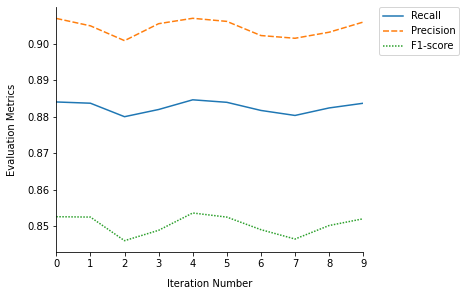

In [284]:
xgb_kfold_plot_data = pd.DataFrame({
    'Recall': recall_scores_nested_cv_xgb,
    'Precision': precision_scores_nested_cv_xgb,
    'F1-score': f1_scores_nested_cv_xgb
})
fig, ax1 = plt.subplots(figsize=(5.5, 4.5))
sns.lineplot(data=xgb_kfold_plot_data, ax=ax1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set(xlim=(0, 9))
ax1.set_xlabel("Iteration Number", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
sns.despine(fig)

### XGB - Testing model with different percentages of train and test data

In [118]:
accuracy_scores_tt_xgb=[]
precision_scores_tt_xgb=[]
recall_scores_tt_xgb=[]
f1_scores_tt_xgb=[]

In [119]:
t0 = time()
count = 0
for ratio in [(0.9,0.1), (0.8,0.2), (0.75,0.25), (0.6,0.4), (0.5,0.5), (0.4,0.6), (0.3, 0.7), (0.15, 0.85)]:
    print("Train: %.2f and Test: %.2f" %(ratio[0], ratio[1]))
    
    X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X, y, train_size=ratio[0], random_state = 1)
    
    y_train_tt.Fault_Type = pd.Categorical(y_train_tt.Fault_Type)
    y_train_tt['Fault_Type_Codes'] = y_train_tt.Fault_Type.cat.codes
    y_train_tt = y_train_tt.drop(columns=['Fault_Type'])
    y_train_tt = y_train_tt.rename(columns={"Fault_Type_Codes": "Fault_Type"})
    print("Encoded Train Labels")
    
    y_test_tt.Fault_Type = pd.Categorical(y_test_tt.Fault_Type)
    y_test_tt['Fault_Type_Codes'] = y_test_tt.Fault_Type.cat.codes
    y_test_tt = y_test_tt.drop(columns=['Fault_Type'])
    y_test_tt = y_test_tt.rename(columns={"Fault_Type_Codes": "Fault_Type"})
    print("Encoded Test Labels")
    
    xgb_tt = XGBClassifier(booster='dart', objective='multi:softmax', eval_metric='merror',
                   tree_method='approx', grow_policy='depthwise', min_child_weight=5,
                   max_depth=5, reg_alpha=2, enable_categorical=True).fit(X_train_tt, y_train_tt.values.flatten())
    
    filePath = "%s/XGB Models/TT Models/tt_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(xgb_tt, fileObj)
    fileObj.close()
    
    ypred_xgb_tt = xgb_tt.predict(X_test_tt)
    
    accuracy_tt_xgb = accuracy_score(y_test_tt, ypred_xgb_tt)
    precision_tt_xgb = precision_score(y_test_tt, ypred_xgb_tt, average='weighted')
    recall_tt_xgb = recall_score(y_test_tt, ypred_xgb_tt, average='weighted')
    f1_score_tt_xgb = f1_score(y_test_tt, ypred_xgb_tt, average='weighted')   
    
    print("Accuracy: %.3f" %(accuracy_tt_xgb))
    print("Precision: %.3f" %(precision_tt_xgb))
    print("Recall: %.3f" %(recall_tt_xgb))
    print("F1 Score: %.3f" %(f1_score_tt_xgb))
    
    accuracy_scores_tt_xgb.append(accuracy_tt_xgb)
    precision_scores_tt_xgb.append(precision_tt_xgb)
    recall_scores_tt_xgb.append(recall_tt_xgb)
    f1_scores_tt_xgb.append(f1_score_tt_xgb)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
train_test_time_xgb = time() - t0

Train: 0.90 and Test: 0.10
Encoded Train Labels
Encoded Test Labels
Accuracy: 0.879
Precision: 0.900
Recall: 0.879
F1 Score: 0.846
-------------------------------------------------------------------------------------------------------------------
Train: 0.80 and Test: 0.20
Encoded Train Labels
Encoded Test Labels
Accuracy: 0.880
Precision: 0.904
Recall: 0.880
F1 Score: 0.848
-------------------------------------------------------------------------------------------------------------------
Train: 0.75 and Test: 0.25
Encoded Train Labels
Encoded Test Labels
Accuracy: 0.880
Precision: 0.903
Recall: 0.880
F1 Score: 0.848
-------------------------------------------------------------------------------------------------------------------
Train: 0.60 and Test: 0.40
Encoded Train Labels
Encoded Test Labels
Accuracy: 0.882
Precision: 0.904
Recall: 0.882
F1 Score: 0.850
-------------------------------------------------------------------------------------------------------------------
Train: 0.50 

In [542]:
print("train_test_time_xgb: %d" %(train_test_time_xgb))

train_test_time_xgb: 257


In [355]:
filePathAcc = "%s/XGB Models/TT Models/tt_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/XGB Models/TT Models/tt_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/XGB Models/TT Models/tt_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/XGB Models/TT Models/tt_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_tt_xgb, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_tt_xgb, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_tt_xgb, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_tt_xgb, filehandle)

In [99]:
filePathAcc = "%s/XGB Models/TT Models/tt_accuracy_scores.txt" %(path)

filePathPrec = "%s/XGB Models/TT Models/tt_precision_scores.txt" %(path)

filePathRecall = "%s/XGB Models/TT Models/tt_recall_scores.txt" %(path)

filePathF1 = "%s/XGB Models/TT Models/tt_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_tt_xgb = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_tt_xgb = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_tt_xgb = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_tt_xgb = data

In [100]:
accuracy_scores_tt_xgb = np.asarray(accuracy_scores_tt_xgb)
precision_scores_tt_xgb = np.asarray(precision_scores_tt_xgb)
recall_scores_tt_xgb = np.asarray(recall_scores_tt_xgb)
f1_scores_tt_xgb = np.asarray(f1_scores_tt_xgb)

print("XGB TT Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_tt_xgb.mean(), 
                                                                 (accuracy_scores_tt_xgb.std())))

print("XGB TT Precision: %.3f, with deviation of: %.3f" %(precision_scores_tt_xgb.mean(), 
                                                                  precision_scores_tt_xgb.std()))

print("XGB TT Recall: %.3f, with deviation of: %.3f" %(recall_scores_tt_xgb.mean(), 
                                                               recall_scores_tt_xgb.std()))

print("XGB TT F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_tt_xgb.mean(), 
                                                                 f1_scores_tt_xgb.std()))

XGB TT Accuracy: 0.881, with deviation of: 0.001
XGB TT Precision: 0.903, with deviation of: 0.001
XGB TT Recall: 0.881, with deviation of: 0.001
XGB TT F1 Score: 0.849, with deviation of: 0.002


C:\Users\aakas\AppData\Local\Temp\ipykernel_39076\2239271419.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  xgb_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)",


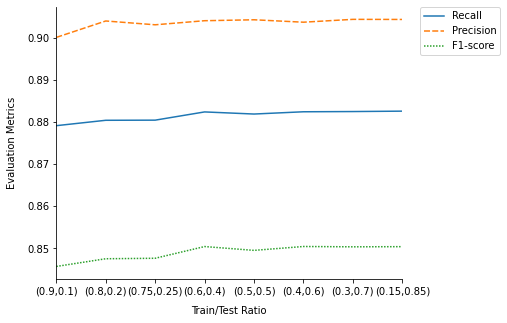

In [285]:
xgb_train_test_plot_data = pd.DataFrame({
    'Recall': recall_scores_tt_xgb,
    'Precision': precision_scores_tt_xgb,
    'F1-score': f1_scores_tt_xgb
})
fig, ax1 = plt.subplots(figsize=(6.2, 5))
xgb_tt_lineplot = sns.lineplot(data=xgb_train_test_plot_data, ax=ax1)
ax1.set(xlim=(0, 7))
xgb_tt_lineplot.set_xticklabels(["(0.9,0.1)", "(0.8,0.2)", "(0.75,0.25)", "(0.6,0.4)", "(0.5,0.5)", 
                   "(0.4,0.6)", "(0.3,0.7)", "(0.15,0.85)"])
ax1.set_xlabel("Train/Test Ratio", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
sns.despine(fig)

### Naive Bayes

In [29]:
input_data_nb = input_data
X_nb = input_data_nb[['Temperature', 'Light', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error']]
y_nb = input_data_nb[['Fault_Type']]

In [31]:
le_y = LabelEncoder()
le_y.fit(y_nb)
y_nb = le_y.transform(y_nb)

le_exit_code = LabelEncoder()
le_exit_code.fit(X_nb.Exit_Code)
X_nb['Exit_Code'] = le_exit_code.transform(X_nb.Exit_Code)

le_time_out = LabelEncoder()
le_time_out.fit(X_nb.Time_Out)
X_nb['Time_Out'] = le_time_out.transform(X_nb.Time_Out)

le_label_log = LabelEncoder()
le_label_log.fit(X_nb.Label_Log)
X_nb['Label_Log'] = le_label_log.transform(X_nb.Label_Log)

le_label_error = LabelEncoder()
le_label_error.fit(X_nb.Label_Error)
X_nb['Label_Error'] = le_label_error.transform(X_nb.Label_Error)

C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\aakas\AppData\Local\Temp\ipykernel_18712\2516623289.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nb['Exit_Code'] = le_exit_code.transform(X_n

In [497]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, stratify=y_nb, random_state = 1)

In [498]:
naive_bayes = MixedNB(alpha=0, categorical_features=[2,3,4,5])

naive_bayes.fit(X_train_nb, y_train_nb)

[19  2  9  4]


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\mixed_naive_bayes\mixed_naive_bayes.py:370: UserWarning: alpha too small will result in numeric errors, setting alpha = 1e-10
  warnings.warn('alpha too small will result in numeric errors, '


MixedNB(alpha=1e-10, var_smoothing=1e-09)

### Naive Bayes - K-fold CV

In [81]:
accuracy_scores_nb = []
precision_scores_nb = []
recall_scores_nb = []
f1_scores_nb = []

In [82]:
cv_outer_nb = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [83]:
# K-fold CV

t0 = time()
y_nb = pd.DataFrame(y_nb)
count = 0
for train_ix_nb, test_ix_nb in cv_outer_nb.split(X_nb, y_nb):
    print(train_ix_nb)
    print(test_ix_nb)
    X_train_nb_cv, X_test_nb_cv = X_nb.iloc[train_ix_nb, :], X_nb.iloc[test_ix_nb, :]
    y_train_nb_cv, y_test_nb_cv = y_nb.iloc[train_ix_nb], y_nb.iloc[test_ix_nb]
    
    alphas = [50]
    
    for alpha in alphas:
    
        nb_random_kfold = MixedNB(alpha=alpha, categorical_features=[2,3,4,5])

        nb_random_kfold_best = nb_random_kfold.fit(X_train_nb_cv, y_train_nb_cv.values.flatten())
        
        filePath = "%s/Naive Bayes Models/KFold Models/kfold_model_%s.sav" %(path, count)
        os.makedirs(os.path.dirname(filePath), exist_ok=True)
        fileObj = open(filePath, 'wb')
        pickle.dump(nb_random_kfold_best, fileObj)
        fileObj.close()

        ypred_nb_random_kfold = nb_random_kfold_best.predict(X_test_nb_cv)
        accuracy_this_fold_nb = accuracy_score(y_test_nb_cv, ypred_nb_random_kfold)
        precision_this_fold_nb = precision_score(y_test_nb_cv, ypred_nb_random_kfold, average='weighted')
        recall_this_fold_nb = recall_score(y_test_nb_cv, ypred_nb_random_kfold, average='weighted')
        f1_score_this_fold_nb = f1_score(y_test_nb_cv, ypred_nb_random_kfold, average='weighted')   

        print("Accuracy: %.3f" %(accuracy_this_fold_nb))
        print("Precision: %.3f" %(precision_this_fold_nb))
        print("Recall: %.3f" %(recall_this_fold_nb))
        print("F1 Score: %.3f" %(f1_score_this_fold_nb))

        accuracy_scores_nb.append(accuracy_this_fold_nb)
        precision_scores_nb.append(precision_this_fold_nb)
        recall_scores_nb.append(recall_this_fold_nb)
        f1_scores_nb.append(f1_score_this_fold_nb)
        
        count = count + 1
        print("-------------------------------------------------------------------------------------------------------------------")

nested_cv_nb_time = time() - t0

[     0      1      2 ... 116898 116899 116900]
[    17     47     53 ... 116880 116888 116901]
[19  2  9  4]
Accuracy: 0.849
Precision: 0.839
Recall: 0.849
F1 Score: 0.836
-------------------------------------------------------------------------------------------------------------------
[     0      1      3 ... 116899 116900 116901]
[     2     19     21 ... 116882 116883 116897]
[19  2  9  4]
Accuracy: 0.845
Precision: 0.836
Recall: 0.845
F1 Score: 0.833
-------------------------------------------------------------------------------------------------------------------
[     0      2      3 ... 116899 116900 116901]
[     1     31     46 ... 116854 116864 116881]
[19  2  9  4]
Accuracy: 0.843
Precision: 0.833
Recall: 0.843
F1 Score: 0.831
-------------------------------------------------------------------------------------------------------------------
[     0      1      2 ... 116899 116900 116901]
[     6     12     25 ... 116892 116893 116894]
[19  2  9  4]
Accuracy: 0.851
Precisi

In [84]:
filePathAcc = "%s/Naive Bayes Models/KFold Models/kfold_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/Naive Bayes Models/KFold Models/kfold_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/Naive Bayes Models/KFold Models/kfold_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/Naive Bayes Models/KFold Models/kfold_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_nb, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_nb, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_nb, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_nb, filehandle)

In [105]:
filePathAcc = "%s/Naive Bayes Models/KFold Models/kfold_accuracy_scores.txt" %(path)

filePathPrec = "%s/Naive Bayes Models/KFold Models/kfold_precision_scores.txt" %(path)

filePathRecall = "%s/Naive Bayes Models/KFold Models/kfold_recall_scores.txt" %(path)

filePathF1 = "%s/Naive Bayes Models/KFold Models/kfold_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_nb = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_nb = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_nb = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_nb = data

In [106]:
accuracy_scores_nb = np.asarray(accuracy_scores_nb)
precision_scores_nb = np.asarray(precision_scores_nb)
recall_scores_nb = np.asarray(recall_scores_nb)
f1_scores_nb = np.asarray(f1_scores_nb)

print("NB K-fold Mean Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_nb.mean(), 
                                                                 (accuracy_scores_nb.std())))

print("NB K-fold Mean Precision: %.3f, with deviation of: %.3f" %(precision_scores_nb.mean(), 
                                                                  precision_scores_nb.std()))

print("NB K-fold Mean Recall: %.3f, with deviation of: %.3f" %(recall_scores_nb.mean(), 
                                                               recall_scores_nb.std()))

print("NB K-fold Mean F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_nb.mean(), 
                                                                 f1_scores_nb.std()))

NB K-fold Mean Accuracy: 0.846, with deviation of: 0.002
NB K-fold Mean Precision: 0.837, with deviation of: 0.003
NB K-fold Mean Recall: 0.846, with deviation of: 0.002
NB K-fold Mean F1 Score: 0.835, with deviation of: 0.002


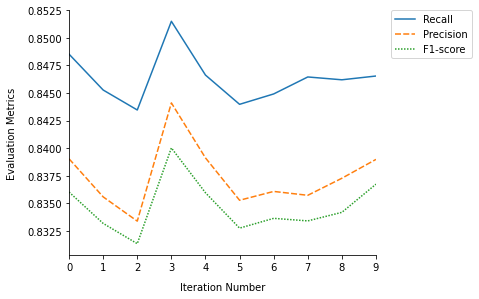

In [286]:
nb_kfold_plot_data = pd.DataFrame({
    'Recall': recall_scores_nb,
    'Precision': precision_scores_nb,
    'F1-score': f1_scores_nb
})
fig, ax1 = plt.subplots(figsize=(5.5, 4.5))
lineplot = sns.lineplot(data=nb_kfold_plot_data, ax=ax1)
ax1.set(xlim=(0, 9))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel("Iteration Number", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
sns.despine(fig)

### Naive Bayes - Train Test

In [361]:
accuracy_scores_tt_nb=[]
precision_scores_tt_nb=[]
recall_scores_tt_nb=[]
f1_scores_tt_nb=[]

In [362]:
t0 = time()
count = 0
for ratio in [(0.9,0.1), (0.8,0.2), (0.75,0.25), (0.6,0.4), (0.5,0.5)]:
    print("Train: %.2f and Test: %.2f" %(ratio[0], ratio[1]))
    
    X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X_nb, y_nb, train_size=ratio[0], stratify=y_nb, random_state = 1)
    
    nb_random_tt = MixedNB(alpha=50, categorical_features=[2,3,4,5]).fit(X_train_tt, y_train_tt.values.flatten())
    
    filePath = "%s/Naive Bayes Models/TT Models/tt_model_%s.sav" %(path, count)
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    fileObj = open(filePath, 'wb')
    pickle.dump(nb_random_tt, fileObj)
    fileObj.close()
    
    ypred_nb_tt = nb_random_tt.predict(X_test_tt)
    
    accuracy_tt = accuracy_score(y_test_tt, ypred_nb_tt)
    precision_tt = precision_score(y_test_tt, ypred_nb_tt, average='weighted')
    recall_tt = recall_score(y_test_tt, ypred_nb_tt, average='weighted')
    f1_score_tt = f1_score(y_test_tt, ypred_nb_tt, average='weighted')   
    
    print("Accuracy: %.3f" %(accuracy_tt))
    print("Precision: %.3f" %(precision_tt))
    print("Recall: %.3f" %(recall_tt))
    print("F1 Score: %.3f" %(f1_score_tt))
    
    accuracy_scores_tt_nb.append(accuracy_tt)
    precision_scores_tt_nb.append(precision_tt)
    recall_scores_tt_nb.append(recall_tt)
    f1_scores_tt_nb.append(f1_score_tt)
    
    count = count + 1
    print("-------------------------------------------------------------------------------------------------------------------")
    
train_test_time_nb = time() - t0

Train: 0.90 and Test: 0.10
[19  2  9  4]
Accuracy: 0.847
Precision: 0.837
Recall: 0.847
F1 Score: 0.834
-------------------------------------------------------------------------------------------------------------------
Train: 0.80 and Test: 0.20
[19  2  9  4]
Accuracy: 0.848
Precision: 0.839
Recall: 0.848
F1 Score: 0.836
-------------------------------------------------------------------------------------------------------------------
Train: 0.75 and Test: 0.25
[19  2  9  4]
Accuracy: 0.848
Precision: 0.839
Recall: 0.848
F1 Score: 0.836
-------------------------------------------------------------------------------------------------------------------
Train: 0.60 and Test: 0.40
[19  2  9  4]
Accuracy: 0.847
Precision: 0.838
Recall: 0.847
F1 Score: 0.836
-------------------------------------------------------------------------------------------------------------------
Train: 0.50 and Test: 0.50
[19  2  9  4]
Accuracy: 0.847
Precision: 0.839
Recall: 0.847
F1 Score: 0.836
----------------

In [363]:
filePathAcc = "%s/Naive Bayes Models/TT Models/tt_accuracy_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathAcc), exist_ok=True)

filePathPrec = "%s/Naive Bayes Models/TT Models/tt_precision_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathPrec), exist_ok=True)

filePathRecall = "%s/Naive Bayes Models/TT Models/tt_recall_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathRecall), exist_ok=True)

filePathF1 = "%s/Naive Bayes Models/TT Models/tt_f1_scores.txt" %(path)
os.makedirs(os.path.dirname(filePathF1), exist_ok=True)

with open(filePathAcc, 'w') as filehandle:
    json.dump(accuracy_scores_tt_nb, filehandle)
    
with open(filePathPrec, 'w') as filehandle:
    json.dump(precision_scores_tt_nb, filehandle)
    
with open(filePathRecall, 'w') as filehandle:
    json.dump(recall_scores_tt_nb, filehandle)
    
with open(filePathF1, 'w') as filehandle:
    json.dump(f1_scores_tt_nb, filehandle)

In [108]:
filePathAcc = "%s/Naive Bayes Models/TT Models/tt_accuracy_scores.txt" %(path)

filePathPrec = "%s/Naive Bayes Models/TT Models/tt_precision_scores.txt" %(path)

filePathRecall = "%s/Naive Bayes Models/TT Models/tt_recall_scores.txt" %(path)

filePathF1 = "%s/Naive Bayes Models/TT Models/tt_f1_scores.txt" %(path)

with open(filePathAcc) as filehandle:
    data = json.load(filehandle)
    accuracy_scores_tt_nb = data
    
with open(filePathPrec) as filehandle:
    data = json.load(filehandle)
    precision_scores_tt_nb = data
    
with open(filePathRecall) as filehandle:
    data = json.load(filehandle)
    recall_scores_tt_nb = data
    
with open(filePathF1) as filehandle:
    data = json.load(filehandle)
    f1_scores_tt_nb = data

In [109]:
accuracy_scores_tt_nb = np.asarray(accuracy_scores_tt_nb)
precision_scores_tt_nb = np.asarray(precision_scores_tt_nb)
recall_scores_tt_nb = np.asarray(recall_scores_tt_nb)
f1_scores_tt_nb = np.asarray(f1_scores_tt_nb)

print("NB TT Accuracy: %.3f, with deviation of: %.3f" %(accuracy_scores_tt_nb.mean(), 
                                                                 (accuracy_scores_tt_nb.std())))

print("NB TT Precision: %.3f, with deviation of: %.3f" %(precision_scores_tt_nb.mean(), 
                                                                  precision_scores_tt_nb.std()))

print("NB TT Recall: %.3f, with deviation of: %.3f" %(recall_scores_tt_nb.mean(), 
                                                               recall_scores_tt_nb.std()))

print("NB TT F1 Score: %.3f, with deviation of: %.3f" %(f1_scores_tt_nb.mean(), 
                                                                 f1_scores_tt_nb.std()))

NB TT Accuracy: 0.847, with deviation of: 0.000
NB TT Precision: 0.838, with deviation of: 0.001
NB TT Recall: 0.847, with deviation of: 0.000
NB TT F1 Score: 0.836, with deviation of: 0.001


C:\Users\aakas\AppData\Local\Temp\ipykernel_39076\391716808.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  nb_tt_lineplot.set_xticklabels(["(0.9,0.1)", " ", "(0.8,0.2)", " ", "(0.75,0.25)", " ", "(0.6,0.4)", " ", "(0.5,0.5)"])


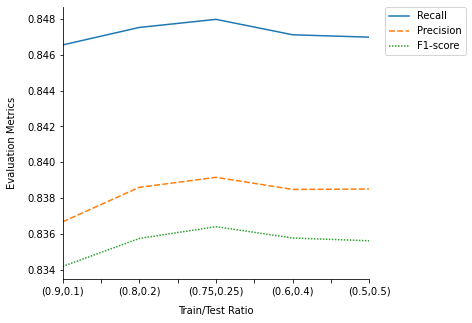

In [287]:
nb_train_test_plot_data = pd.DataFrame({
    'Recall': recall_scores_tt_nb,
    'Precision': precision_scores_tt_nb,
    'F1-score': f1_scores_tt_nb
})
fig, ax1 = plt.subplots(figsize=(5.5, 5))
nb_tt_lineplot = sns.lineplot(data=nb_train_test_plot_data, ax=ax1)
ax1.set(xlim=(0, 4))
nb_tt_lineplot.set_xticklabels(["(0.9,0.1)", " ", "(0.8,0.2)", " ", "(0.75,0.25)", " ", "(0.6,0.4)", " ", "(0.5,0.5)"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel("Train/Test Ratio", labelpad=10)
ax1.set_ylabel("Evaluation Metrics", labelpad=10)
sns.despine(fig)

## Supervised fault type prediction - Naive Model

In [111]:
naive_model_nop = pickle.load(open("%s/Naive Models/naive_model_nop.sav" %(path), 'rb'))

naive_model_flp = pickle.load(open("%s/Naive Models/naive_model_flp.sav" %(path), 'rb'))

naive_model_none = pickle.load(open("%s/Naive Models/naive_model_none.sav" %(path), 'rb'))

In [117]:
t0 = time()
y_pred_naive_nop = naive_model_nop.predict(X_test)
naive_pred_time_nop = time() - t0

In [118]:
print("Prediction time for %i samples: %d" %(X_test.shape[0], naive_pred_time_nop))

Prediction time for 58451 samples: 0


In [119]:
naive_nop_accuracy = accuracy_score(y_test, y_pred_naive_nop)
print("Naive Model NOP Accuracy: %s" %(naive_nop_accuracy))

Naive Model NOP Accuracy: 0.14458264187096884


In [120]:
naive_nop_recall = recall_score(y_test, y_pred_naive_nop, average='weighted')
print("Naive Model NOP Recall: %s" %(naive_nop_recall))

Naive Model NOP Recall: 0.14458264187096884


In [121]:
naive_nop_precision = precision_score(y_test, y_pred_naive_nop, average='weighted')
print("Naive Model NOP Precision: %s" %(naive_nop_precision))

Naive Model NOP Precision: 0.020904140330388832


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
naive_nop_f1 = f1_score(y_test, y_pred_naive_nop, average='weighted')
print("Naive Model NOP Weighted F1 score: %s" %(naive_nop_f1))

Naive Model NOP Weighted F1 score: 0.03652709654275081


In [123]:
t0 = time()
y_pred_naive_flp = naive_model_flp.predict(X_test)
naive_pred_time_flp = time() - t0

In [124]:
print("Prediction time for %i samples: %d" %(X_test.shape[0], naive_pred_time_flp))

Prediction time for 58451 samples: 0


In [125]:
naive_flp_accuracy = accuracy_score(y_test, y_pred_naive_flp)
print("Naive Model FLP Accuracy: %s" %(naive_flp_accuracy))

Naive Model FLP Accuracy: 0.4277086790645156


In [126]:
naive_flp_recall = recall_score(y_test, y_pred_naive_flp, average='weighted')
print("Naive Model FLP Recall: %s" %(naive_flp_recall))

Naive Model FLP Recall: 0.4277086790645156


In [127]:
naive_flp_precision = precision_score(y_test, y_pred_naive_flp, average='weighted')
print("Naive Model FLP Precision: %s" %(naive_flp_precision))

Naive Model FLP Precision: 0.1829347141471128


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
naive_flp_f1 = f1_score(y_test, y_pred_naive_flp, average='weighted')
print("Naive Model FLP Weighted F1 score: %s" %(naive_flp_f1))

Naive Model FLP Weighted F1 score: 0.2562633635693494


In [129]:
t0 = time()
y_pred_naive_none = naive_model_none.predict(X_test)
naive_pred_time_none = time() - t0

In [130]:
print("Prediction time for %i samples: %d" %(X_test.shape[0], naive_pred_time_none))

Prediction time for 58451 samples: 0


In [131]:
naive_none_accuracy = accuracy_score(y_test, y_pred_naive_none)
print("Naive Model NONE Accuracy: %s" %(naive_none_accuracy))

Naive Model NONE Accuracy: 0.4277086790645156


In [132]:
naive_none_recall = recall_score(y_test, y_pred_naive_none, average='weighted')
print("Naive Model NONE Recall: %s" %(naive_none_recall))

Naive Model NONE Recall: 0.4277086790645156


In [133]:
naive_none_precision = precision_score(y_test, y_pred_naive_none, average='weighted')
print("Naive Model NONE Precision: %s" %(naive_none_precision))

Naive Model NONE Precision: 0.1829347141471128


C:\Users\aakas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
naive_none_f1 = f1_score(y_test, y_pred_naive_none, average='weighted')
print("Naive Model NONE Weighted F1 score: %s" %(naive_none_f1))

Naive Model NONE Weighted F1 score: 0.2562633635693494


In [135]:
naive_accuracy_scores = np.array([naive_nop_accuracy, naive_flp_accuracy, naive_none_accuracy])
naive_recall_scores = np.array([naive_nop_recall, naive_flp_recall, naive_none_recall])
naive_precision_scores = np.array([naive_nop_precision, naive_flp_precision, naive_none_precision])
naive_f1_scores = np.array([naive_nop_f1, naive_flp_f1, naive_none_f1])

In [136]:
print("Naive Mean Accuracy: %.3f, with deviation of: %.3f" %(naive_accuracy_scores.mean(), 
                                                                 (naive_accuracy_scores.std())))

print("Naive Mean Recall Score: %.3f, with deviation of: %.3f" %(naive_recall_scores.mean(), 
                                                                 naive_recall_scores.std()))

print("Naive Mean Precision Score: %.3f, with deviation of: %.3f" %(naive_precision_scores.mean(), 
                                                                 naive_precision_scores.std()))

print("Naive Mean F1 Score: %.3f, with deviation of: %.3f" %(naive_f1_scores.mean(), 
                                                                 naive_f1_scores.std()))

Naive Mean Accuracy: 0.333, with deviation of: 0.133
Naive Mean Recall Score: 0.333, with deviation of: 0.133
Naive Mean Precision Score: 0.129, with deviation of: 0.076
Naive Mean F1 Score: 0.183, with deviation of: 0.104


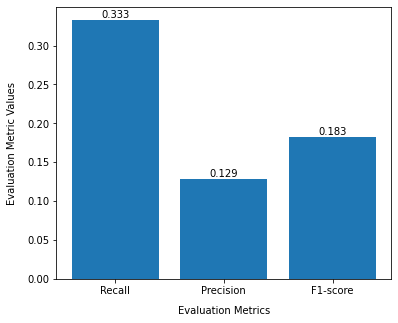

In [289]:
fig, ax1 = plt.subplots(figsize=(6, 5))

values = [
    round(np.mean([naive_nop_recall, naive_flp_recall, naive_none_recall]), 3),
    round(np.mean([naive_nop_precision, naive_flp_precision, naive_none_precision]), 3),
    round(np.mean([naive_nop_f1, naive_flp_f1, naive_none_f1]), 3)
]

ax1.bar(['Recall', 'Precision', 'F1-score'], values)

for container in ax1.containers:
    ax1.bar_label(container)
    
ax1.set_xlabel("Evaluation Metrics", labelpad=10)
ax1.set_ylabel("Evaluation Metric Values", labelpad=10)

plt.show()

## Supervised fault type prediction - Random Forest

In [140]:
rfc = pickle.load(open("%s/Random Forest Models/KFold Models/kfold_model_4.sav" %(path), 'rb'))

In [141]:
t0 = time()
y_pred_rf = rfc.predict(X_test)
rf_pred_time = time() - t0

In [142]:
print("Prediction time for %i samples: %d" %(X_test.shape[0], rf_pred_time))

Prediction time for 58451 samples: 0


In [143]:
rf_cls_report = classification_report(y_test,
                            y_pred_rf,
                            output_dict=True)

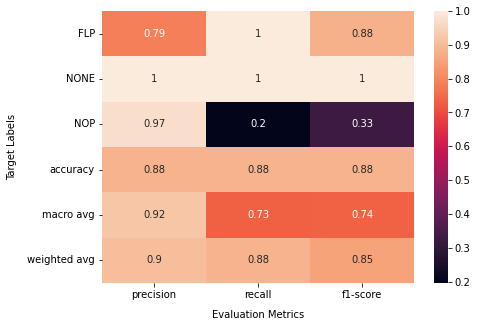

In [290]:
fig, ax1 = plt.subplots(figsize=(7, 5))
sns.heatmap(pd.DataFrame(rf_cls_report).iloc[:-1, :].T, annot=True)
ax1.set_xlabel("Evaluation Metrics", labelpad=10)
ax1.set_ylabel("Target Labels", labelpad=10)
plt.show()

In [217]:
rfc_importance = rfc.feature_importances_

In [218]:
for i,v in enumerate(rfc_importance):
    print('Feature: %0d, Score: %.3f' % (i,v))

Feature: 0, Score: 0.260
Feature: 1, Score: 0.288
Feature: 2, Score: 0.113
Feature: 3, Score: 0.128
Feature: 4, Score: 0.395
Feature: 5, Score: 0.161


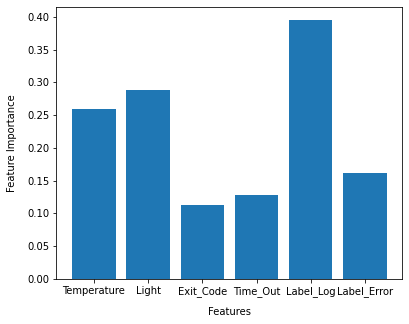

In [291]:
fig, ax1 = plt.subplots(figsize=(6.2, 5))
plt.bar(['Temperature', 'Light', 'Exit_Code', 'Time_Out', 'Label_Log', 'Label_Error'], rfc_importance)
ax1.set_xlabel("Features", labelpad=10)
ax1.set_ylabel("Feature Importance", labelpad=10)
plt.show()

### Predictions for testing Application data and Software Properties separately

In [202]:
t0 = time()
y_pred_rf_app = rfc_app.predict(X_test_app)
rf_app_pred_time = time() - t0

In [203]:
print("Prediction time for %i samples: %d" %(X_test_app.shape[0], rf_app_pred_time))

Prediction time for 29226 samples: 0


In [204]:
rf_app_cls_report = classification_report(y_test_app, 
                            y_pred_rf_app,
                            output_dict=True)

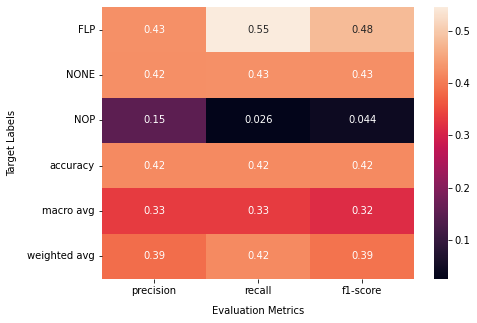

In [292]:
fig, ax1 = plt.subplots(figsize=(7, 5))
sns.heatmap(pd.DataFrame(rf_app_cls_report).iloc[:-1, :].T, annot=True)
ax1.set_xlabel("Evaluation Metrics", labelpad=10)
ax1.set_ylabel("Target Labels", labelpad=10)
plt.show()

In [209]:
t0 = time()
y_pred_rf_swp = rfc_swp.predict(X_test_swp)
rf_swp_pred_time = time() - t0

In [210]:
print("Prediction time for %i samples: %d" %(X_test_swp.shape[0], rf_swp_pred_time))

Prediction time for 29226 samples: 0


In [211]:
rf_swp_cls_report = classification_report(y_test_swp, 
                                          y_pred_rf_swp, 
                                          output_dict=True)

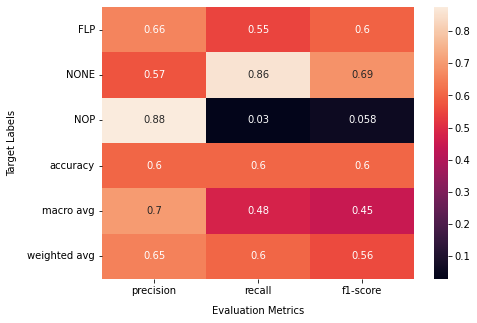

In [293]:
fig, ax1 = plt.subplots(figsize=(7, 5))
sns.heatmap(pd.DataFrame(rf_swp_cls_report).iloc[:-1, :].T, annot=True)
ax1.set_xlabel("Evaluation Metrics", labelpad=10)
ax1.set_ylabel("Target Labels", labelpad=10)
plt.show()

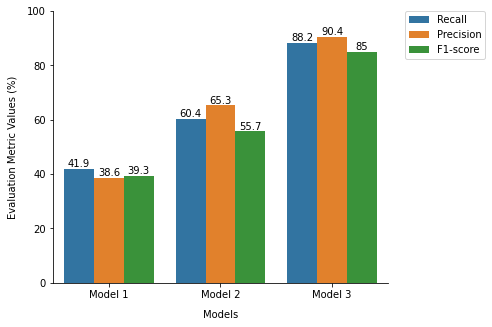

In [311]:
df = pd.DataFrame({
    'Models': ['Model 1', 'Model 2', 'Model 3'],
    'Recall': [round(rf_app_recall,3)*100, round(rf_swp_recall,3)*100, round(recall_scores.mean(),3)*100],
    'Precision': [round(rf_app_precision,3)*100, round(rf_swp_precision,3)*100, round(precision_scores.mean(),3)*100],
    'F1-score': [round(rf_app_f1,3)*100, round(rf_swp_f1,3)*100, round(f1_scores.mean(),3)*100]
})
xlabel = 'Models'
ylabel = "Evaluation Metric Values (%)"
fig, ax1 = plt.subplots(figsize=(6, 5))
tidy = df.melt(id_vars=xlabel).rename(columns=str.title)
tidy = tidy.rename(columns={"Value": ylabel, "Variable": "Metrics"})
bars = sns.barplot(x=xlabel, y=ylabel, hue='Metrics', data=tidy, ax=ax1)
ax1.set(ylim=(0, 100))

for container in ax1.containers:
    ax1.bar_label(container)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax1.set_xlabel(xlabel, labelpad=10)
ax1.set_ylabel(ylabel, labelpad=10)

sns.despine(fig)

# Plots

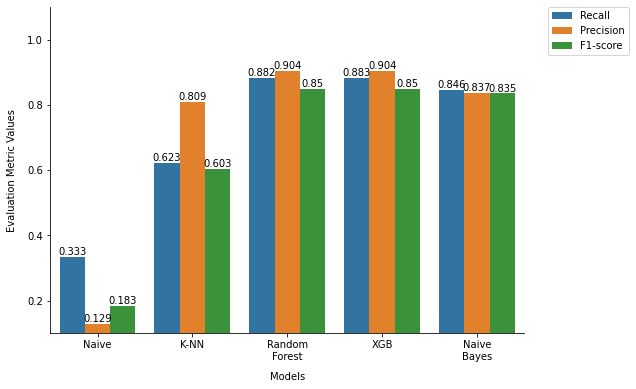

In [295]:
df = pd.DataFrame({
    'Models': ['Naive', 'K-NN', 'Random\nForest', 'XGB', 'Naive\nBayes'],
#     'Accuracy': [round(naive_accuracy_scores.mean(),3), round(knn_accuracy,3), round(accuracy_scores.mean(),3), 
#                  round(nested_cv_xgb_accuracy,3)],
    'Recall': [round(naive_recall_scores.mean(),3), 
               round(recall_scores_knn.mean(),3), 
               round(recall_scores.mean(),3),
               round(recall_scores_nested_cv_xgb.mean(),3), 
               round(recall_scores_nb.mean(),3)],
    'Precision': [round(naive_precision_scores.mean(),3), 
                  round(precision_scores_knn.mean(),3), 
                  round(precision_scores.mean(),3), 
                  round(precision_scores_nested_cv_xgb.mean(),3), 
                  round(precision_scores_nb.mean(),3)],
    'F1-score': [round(naive_f1_scores.mean(),3), 
                 round(f1_scores_knn.mean(),3), 
                 round(f1_scores.mean(),3), 
                 round(f1_scores_nested_cv_xgb.mean(),3), 
                 round(f1_scores_nb.mean(),3)]
})
xlabel = 'Models'
ylabel = 'Evaluation Metric Values'
fig, ax1 = plt.subplots(figsize=(8.5, 6))
tidy = df.melt(id_vars=xlabel).rename(columns=str.title)
tidy = tidy.rename(columns={"Value": ylabel, "Variable": "Metrics"})
sns.barplot(x=xlabel, y=ylabel, hue='Metrics', data=tidy, ax=ax1)
ax1.set(ylim=(0.1, 1.1))

for container in ax1.containers:
    ax1.bar_label(container)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax1.set_xlabel(xlabel, labelpad=10)
ax1.set_ylabel(ylabel, labelpad=10)

sns.despine(fig)